In [2]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

In [4]:
ls ../../data/interim

ls: cannot access '../../data/interim': No such file or directory


In [3]:
path = 'interim'
raw_directory = os.path.join('..','data',f'{path}/')

In [4]:
all_files = glob.glob(os.path.join(raw_directory, "*.csv")) # change "*.xlsx" for excel files
df_from_each_file = (pd.read_csv(f) for f in all_files)    # change to `pd.read_excel(f)` for excel files
df   = pd.concat(df_from_each_file, ignore_index=True)     # combine into one large dataframe

# cleanup columns
#df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()
# df.columns = df.columns.str.strip().str.lower().str.replace('-', '_').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [5]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126360 non-null  object
 1   offenses      1126360 non-null  int64 
 2   offense_type  1126360 non-null  object
 3   block_range   1126203 non-null  object
 4   street_name   1126357 non-null  object
 5   type          1126360 non-null  object
 6   suffix        1126360 non-null  object
 7   beat          1126344 non-null  object
 8   premise       1092768 non-null  object
dtypes: int64(1), object(8)
memory usage: 77.3+ MB


# Show null data

In [7]:
df.apply(lambda x: sum(x.isnull()))

date_time           0
offenses            0
offense_type        0
block_range       157
street_name         3
type                0
suffix              0
beat               16
premise         33592
dtype: int64

In [8]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
premise,2.98
block_range,0.01
date_time,0.00
offenses,0.00
offense_type,0.00
street_name,0.00
type,0.00
suffix,0.00
beat,0.00


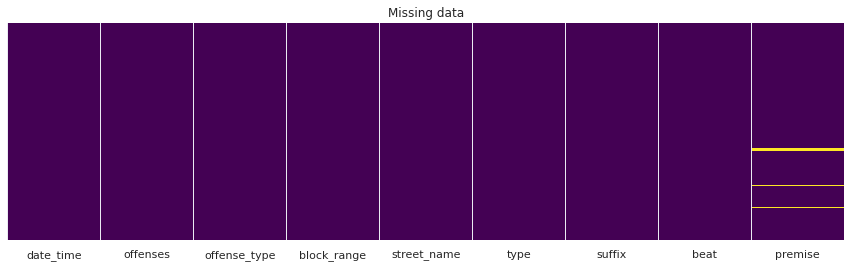

In [9]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1126360 non-null  object
 1   offenses      1126360 non-null  int64 
 2   offense_type  1126360 non-null  object
 3   block_range   1126203 non-null  object
 4   street_name   1126357 non-null  object
 5   type          1126360 non-null  object
 6   suffix        1126360 non-null  object
 7   beat          1126344 non-null  object
 8   premise       1092768 non-null  object
dtypes: int64(1), object(8)
memory usage: 77.3+ MB


In [11]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


# convert datetime

In [12]:
df.date_time = pd.to_datetime(df.date_time)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date_time     1126360 non-null  datetime64[ns]
 1   offenses      1126360 non-null  int64         
 2   offense_type  1126360 non-null  object        
 3   block_range   1126203 non-null  object        
 4   street_name   1126357 non-null  object        
 5   type          1126360 non-null  object        
 6   suffix        1126360 non-null  object        
 7   beat          1126344 non-null  object        
 8   premise       1092768 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 77.3+ MB


In [14]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


# Load w data

In [15]:
ls ../data/raw/weather_data/

b5af47a41a784be4c6fca0b53302f0a1.csv*


In [16]:
ls

2009.ipynb  2013.ipynb  2017.ipynb    crime_merge.ipynb   Untitled.ipynb
2010.ipynb  2014.ipynb  2018.ipynb    EXAMPLES.ipynb*     weather_Explore.ipynb
2011.ipynb  2015.ipynb  2018_n.ipynb  EXAMPLES_og.ipynb*
2012.ipynb  2016.ipynb  2020.ipynb    temp_explore.ipynb


In [18]:
file_name = 'b5af47a41a784be4c6fca0b53302f0a1.csv'
w_data = os.path.join('..', 'data','raw','weather_data',f'{file_name}')

In [19]:
wd_df = pd.read_csv(w_data)

In [20]:
wd_df

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1104537600,2005-01-01 00:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,293.66,294.09,292.16,293.78,1021,NaN,NaN,89,3.10,100,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1104541200,2005-01-01 01:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,292.09,292.65,291.16,292.18,1021,NaN,NaN,100,2.60,100,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
2,1104544800,2005-01-01 02:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,292.14,292.71,290.18,292.18,1022,NaN,NaN,100,3.60,110,NaN,NaN,NaN,NaN,90,741,Fog,fog,50n
3,1104548400,2005-01-01 03:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,291.34,291.83,291.16,291.58,1022,NaN,NaN,100,3.10,130,NaN,NaN,NaN,NaN,90,741,Fog,fog,50n
4,1104552000,2005-01-01 04:00:00 +0000 UTC,-21600,Houston,29.760427,-95.369803,291.07,291.53,290.16,291.58,1022,NaN,NaN,100,3.10,110,NaN,NaN,NaN,NaN,90,741,Fog,fog,50n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151260,1625166000,2021-07-01 19:00:00 +0000 UTC,-18000,Houston,29.760427,-95.369803,304.53,310.84,303.16,306.60,1014,NaN,NaN,67,0.45,293,0.51,NaN,NaN,NaN,75,500,Rain,light rain,10d
151261,1625169600,2021-07-01 20:00:00 +0000 UTC,-18000,Houston,29.760427,-95.369803,304.27,310.47,302.08,307.22,1013,NaN,NaN,68,1.34,158,1.81,NaN,NaN,NaN,40,501,Rain,moderate rain,10d
151262,1625173200,2021-07-01 21:00:00 +0000 UTC,-18000,Houston,29.760427,-95.369803,304.86,311.86,302.66,307.08,1013,NaN,NaN,68,0.89,225,1.81,NaN,NaN,NaN,75,501,Rain,moderate rain,10d
151263,1625176800,2021-07-01 22:00:00 +0000 UTC,-18000,Houston,29.760427,-95.369803,305.26,312.10,303.79,306.53,1013,NaN,NaN,65,0.89,203,1.81,NaN,NaN,NaN,20,501,Rain,moderate rain,10d


## Filter columns

In [21]:
wd_df = wd_df[['dt','temp', 'feels_like',
 'temp_min',
 'temp_max', 'humidity',
 'wind_speed', 'rain_1h','snow_1h',
 'clouds_all',
 'weather_main',
 'weather_description',]]

In [22]:
wd_df

,dt,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,1104537600,293.66,294.09,292.16,293.78,89,3.10,NaN,NaN,75,Clouds,broken clouds
1,1104541200,292.09,292.65,291.16,292.18,100,2.60,NaN,NaN,40,Clouds,scattered clouds
2,1104544800,292.14,292.71,290.18,292.18,100,3.60,NaN,NaN,90,Fog,fog
3,1104548400,291.34,291.83,291.16,291.58,100,3.10,NaN,NaN,90,Fog,fog
4,1104552000,291.07,291.53,290.16,291.58,100,3.10,NaN,NaN,90,Fog,fog
...,...,...,...,...,...,...,...,...,...,...,...,...
151260,1625166000,304.53,310.84,303.16,306.60,67,0.45,0.51,NaN,75,Rain,light rain
151261,1625169600,304.27,310.47,302.08,307.22,68,1.34,1.81,NaN,40,Rain,moderate rain
151262,1625173200,304.86,311.86,302.66,307.08,68,0.89,1.81,NaN,75,Rain,moderate rain
151263,1625176800,305.26,312.10,303.79,306.53,65,0.89,1.81,NaN,20,Rain,moderate rain


# Show null data

In [24]:
wd_df.apply(lambda x: sum(x.isnull()))

dt                          0
temp                        0
feels_like                  0
temp_min                    0
temp_max                    0
humidity                    0
wind_speed                  0
rain_1h                123166
snow_1h                151091
clouds_all                  0
weather_main                0
weather_description         0
dtype: int64

In [25]:
# change nan to zero
wd_df['rain_1h'] = wd_df['rain_1h'].fillna(0)
wd_df['snow_1h'] = wd_df['snow_1h'].fillna(0)

<ipython-input-25-b31162f7e4e6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-b31162f7e4e6>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



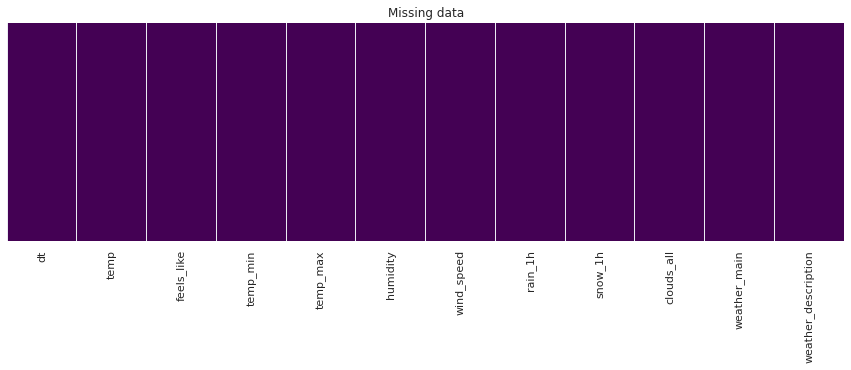

In [27]:
plt.figure(figsize=(15,4))
sns.heatmap(wd_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Convert to datetime

In [28]:
# convert to datetime
wd_df.dt = pd.to_datetime(wd_df['dt'], unit='s')

/home/frank/miniconda3/envs/crdata/lib/python3.8/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
wd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151265 entries, 0 to 151264
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dt                   151265 non-null  datetime64[ns]
 1   temp                 151265 non-null  float64       
 2   feels_like           151265 non-null  float64       
 3   temp_min             151265 non-null  float64       
 4   temp_max             151265 non-null  float64       
 5   humidity             151265 non-null  int64         
 6   wind_speed           151265 non-null  float64       
 7   rain_1h              151265 non-null  float64       
 8   snow_1h              151265 non-null  float64       
 9   clouds_all           151265 non-null  int64         
 10  weather_main         151265 non-null  object        
 11  weather_description  151265 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 13.8

In [47]:
wd_df.head()

,dt,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2005-01-01 00:00:00,68.918,69.692,66.218,69.134,89,3.1,0.0,0.0,75,Clouds,broken clouds
1,2005-01-01 01:00:00,66.092,67.100,64.418,66.254,100,2.6,0.0,0.0,40,Clouds,scattered clouds
2,2005-01-01 02:00:00,66.182,67.208,62.654,66.254,100,3.6,0.0,0.0,90,Fog,fog
3,2005-01-01 03:00:00,64.742,65.624,64.418,65.174,100,3.1,0.0,0.0,90,Fog,fog
4,2005-01-01 04:00:00,64.256,65.084,62.618,65.174,100,3.1,0.0,0.0,90,Fog,fog


In [49]:
wd_df.rename(columns = {'dt':'date_time'}, inplace = True)

/home/frank/miniconda3/envs/crdata/lib/python3.8/site-packages/pandas/core/frame.py:4295: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
wd_df

,date_time,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2005-01-01 00:00:00,68.918,69.692,66.218,69.134,89,3.10,0.00,0.0,75,Clouds,broken clouds
1,2005-01-01 01:00:00,66.092,67.100,64.418,66.254,100,2.60,0.00,0.0,40,Clouds,scattered clouds
2,2005-01-01 02:00:00,66.182,67.208,62.654,66.254,100,3.60,0.00,0.0,90,Fog,fog
3,2005-01-01 03:00:00,64.742,65.624,64.418,65.174,100,3.10,0.00,0.0,90,Fog,fog
4,2005-01-01 04:00:00,64.256,65.084,62.618,65.174,100,3.10,0.00,0.0,90,Fog,fog
...,...,...,...,...,...,...,...,...,...,...,...,...
151260,2021-07-01 19:00:00,88.484,99.842,86.018,92.210,67,0.45,0.51,0.0,75,Rain,light rain
151261,2021-07-01 20:00:00,88.016,99.176,84.074,93.326,68,1.34,1.81,0.0,40,Rain,moderate rain
151262,2021-07-01 21:00:00,89.078,101.678,85.118,93.074,68,0.89,1.81,0.0,75,Rain,moderate rain
151263,2021-07-01 22:00:00,89.798,102.110,87.152,92.084,65,0.89,1.81,0.0,20,Rain,moderate rain


## Convert temp

In [30]:
def Celsius_to_Kelvin(C):
    return (C + 273.15)

def Kelvin_to_Celsius(K):
    return (K - 273.15)


def Kelvin_to_Farh(K):
    return (K -273.15) * 9/5 + 32 


def fahr_to_celsius(temp_fahr):
    """Convert Fahrenheit to Celsius
    
    Return Celsius conversion of input"""
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius

In [31]:
wd_df['temp'] = Kelvin_to_Farh(wd_df["temp"])
wd_df['temp_min'] = Kelvin_to_Farh(wd_df["temp_min"])
wd_df['feels_like'] = Kelvin_to_Farh(wd_df["feels_like"])
wd_df['temp_max'] = Kelvin_to_Farh(wd_df["temp_max"])

<ipython-input-31-d2fb92fe10e0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-d2fb92fe10e0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-d2fb92fe10e0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-d2fb92f

In [32]:
wd_df.head()

,dt,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2005-01-01 00:00:00,68.918,69.692,66.218,69.134,89,3.1,0.0,0.0,75,Clouds,broken clouds
1,2005-01-01 01:00:00,66.092,67.100,64.418,66.254,100,2.6,0.0,0.0,40,Clouds,scattered clouds
2,2005-01-01 02:00:00,66.182,67.208,62.654,66.254,100,3.6,0.0,0.0,90,Fog,fog
3,2005-01-01 03:00:00,64.742,65.624,64.418,65.174,100,3.1,0.0,0.0,90,Fog,fog
4,2005-01-01 04:00:00,64.256,65.084,62.618,65.174,100,3.1,0.0,0.0,90,Fog,fog


In [33]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date_time     1126360 non-null  datetime64[ns]
 1   offenses      1126360 non-null  int64         
 2   offense_type  1126360 non-null  object        
 3   block_range   1126203 non-null  object        
 4   street_name   1126357 non-null  object        
 5   type          1126360 non-null  object        
 6   suffix        1126360 non-null  object        
 7   beat          1126344 non-null  object        
 8   premise       1092768 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 77.3+ MB


In [35]:
wd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151265 entries, 0 to 151264
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dt                   151265 non-null  datetime64[ns]
 1   temp                 151265 non-null  float64       
 2   feels_like           151265 non-null  float64       
 3   temp_min             151265 non-null  float64       
 4   temp_max             151265 non-null  float64       
 5   humidity             151265 non-null  int64         
 6   wind_speed           151265 non-null  float64       
 7   rain_1h              151265 non-null  float64       
 8   snow_1h              151265 non-null  float64       
 9   clouds_all           151265 non-null  int64         
 10  weather_main         151265 non-null  object        
 11  weather_description  151265 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 13.8

In [36]:
result = pd.concat([df, wd_df], axis=1)

In [38]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1126360 non-null  datetime64[ns]
 1   offenses             1126360 non-null  int64         
 2   offense_type         1126360 non-null  object        
 3   block_range          1126203 non-null  object        
 4   street_name          1126357 non-null  object        
 5   type                 1126360 non-null  object        
 6   suffix               1126360 non-null  object        
 7   beat                 1126344 non-null  object        
 8   premise              1092768 non-null  object        
 9   dt                   151265 non-null   datetime64[ns]
 10  temp                 151265 non-null   float64       
 11  feels_like           151265 non-null   float64       
 12  temp_min             151265 non-null   float64       
 1

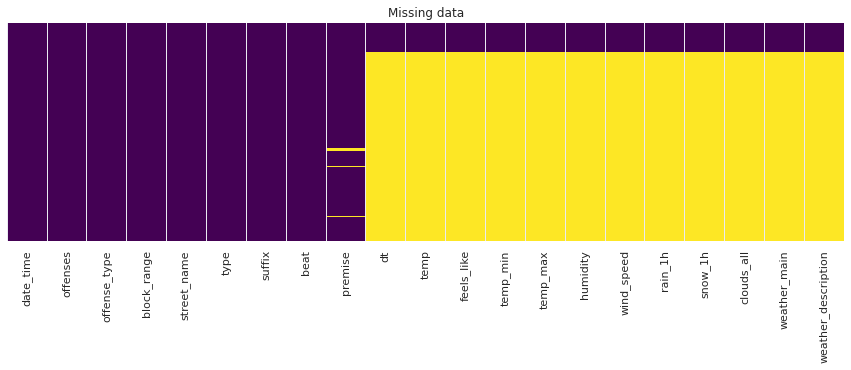

In [39]:
plt.figure(figsize=(15,4))
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [40]:
result = pd.concat([ wd_df,df], axis=1)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   dt                   151265 non-null   datetime64[ns]
 1   temp                 151265 non-null   float64       
 2   feels_like           151265 non-null   float64       
 3   temp_min             151265 non-null   float64       
 4   temp_max             151265 non-null   float64       
 5   humidity             151265 non-null   float64       
 6   wind_speed           151265 non-null   float64       
 7   rain_1h              151265 non-null   float64       
 8   snow_1h              151265 non-null   float64       
 9   clouds_all           151265 non-null   float64       
 10  weather_main         151265 non-null   object        
 11  weather_description  151265 non-null   object        
 12  date_time            1126360 non-null  datetime64[ns]
 1

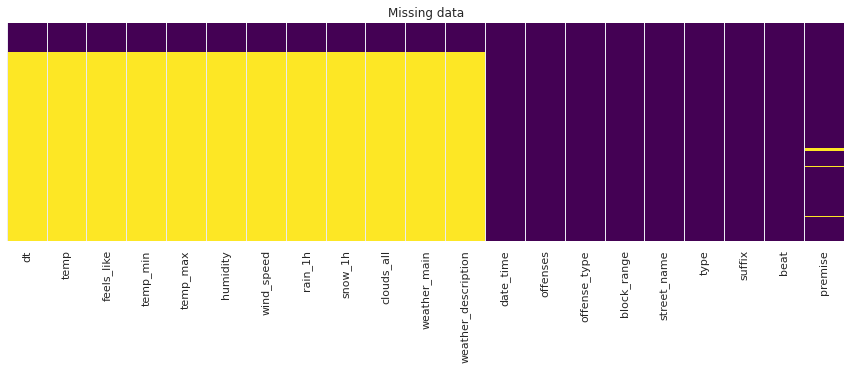

In [41]:
plt.figure(figsize=(15,4))
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [42]:
result

,dt,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2005-01-01 00:00:00,68.918,69.692,66.218,69.134,89.0,3.1,0.0,0.0,75.0,Clouds,broken clouds,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2005-01-01 01:00:00,66.092,67.100,64.418,66.254,100.0,2.6,0.0,0.0,40.0,Clouds,scattered clouds,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2005-01-01 02:00:00,66.182,67.208,62.654,66.254,100.0,3.6,0.0,0.0,90.0,Fog,fog,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2005-01-01 03:00:00,64.742,65.624,64.418,65.174,100.0,3.1,0.0,0.0,90.0,Fog,fog,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2005-01-01 04:00:00,64.256,65.084,62.618,65.174,100.0,3.1,0.0,0.0,90.0,Fog,fog,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126355,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-27 03:00:00,1,Robbery,4100-4199,DARWIN,-,-,UNK,"Road, Street, or Sidewalk"
1126356,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-28 22:00:00,1,Theft,17700-17799,EASTEX,FWY,-,UNK,Apartment Parking Lot
1126357,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-28 22:00:00,1,Theft,900-999,ST EMANUEL,-,-,UNK,Other Parking Lot
1126358,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-30 23:00:00,1,AutoTheft,10800-10899,SHADY,LN,-,UNK,Service or Gas Station


In [51]:
new = pd.merge(df, wd_df, on=['date_time'])

In [52]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167462 entries, 0 to 1167461
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1167462 non-null  datetime64[ns]
 1   offenses             1167462 non-null  int64         
 2   offense_type         1167462 non-null  object        
 3   block_range          1167301 non-null  object        
 4   street_name          1167459 non-null  object        
 5   type                 1167462 non-null  object        
 6   suffix               1167462 non-null  object        
 7   beat                 1167446 non-null  object        
 8   premise              1132998 non-null  object        
 9   temp                 1167462 non-null  float64       
 10  feels_like           1167462 non-null  float64       
 11  temp_min             1167462 non-null  float64       
 12  temp_max             1167462 non-null  float64       
 1

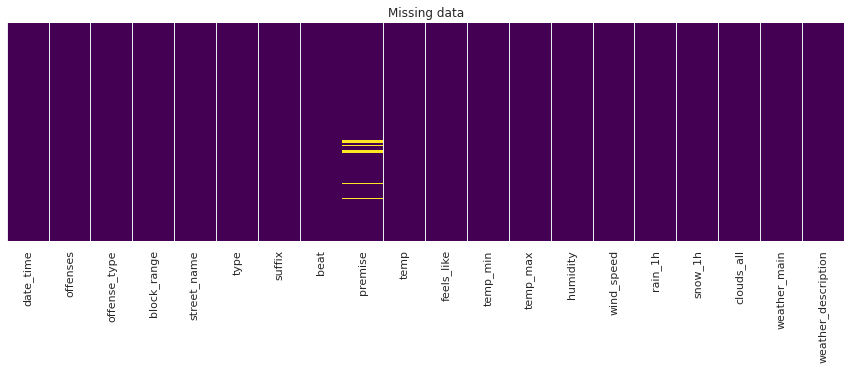

In [53]:
plt.figure(figsize=(15,4))
sns.heatmap(new.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [54]:
new.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear


In [56]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


In [57]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167462 entries, 0 to 1167461
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1167462 non-null  datetime64[ns]
 1   offenses             1167462 non-null  int64         
 2   offense_type         1167462 non-null  object        
 3   block_range          1167301 non-null  object        
 4   street_name          1167459 non-null  object        
 5   type                 1167462 non-null  object        
 6   suffix               1167462 non-null  object        
 7   beat                 1167446 non-null  object        
 8   premise              1132998 non-null  object        
 9   temp                 1167462 non-null  float64       
 10  feels_like           1167462 non-null  float64       
 11  temp_min             1167462 non-null  float64       
 12  temp_max             1167462 non-null  float64       
 1

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126360 entries, 0 to 1126359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date_time     1126360 non-null  datetime64[ns]
 1   offenses      1126360 non-null  int64         
 2   offense_type  1126360 non-null  object        
 3   block_range   1126203 non-null  object        
 4   street_name   1126357 non-null  object        
 5   type          1126360 non-null  object        
 6   suffix        1126360 non-null  object        
 7   beat          1126344 non-null  object        
 8   premise       1092768 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 77.3+ MB


In [63]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N


In [60]:
new.date_time.dt.year.unique()

array([2009, 2008, 2005, 2006, 2007, 2010, 2011, 2012, 2013, 2021, 2020,
       2014, 2019, 2015, 2016, 2017, 2018])

In [61]:
df.date_time.dt.year.unique()

array([2009, 2008, 2002, 2000, 2005, 2006, 2003, 1990, 2007, 2004, 1965,
       1963, 2001, 1991, 1995, 1992, 1978, 1994, 2010, 1966, 1999, 1985,
       1974, 2011, 1983, 1977, 1998, 1969, 1959, 1980, 1996, 1976, 1981,
       1972, 1971, 1979, 1988, 1970, 1964, 1993, 2012, 1987, 2013, 1982,
       2021, 1997, 1975, 1989, 2029, 1973, 2020, 2014, 2033, 2019, 1986,
       1914, 1924, 1984, 1920, 2015, 1915, 1916, 2016, 1926, 1918, 1921,
       1919, 2017, 1917, 1927, 1953, 2018])

In [67]:
data = new[(new['date_time']< "2018-04-30") & (new['date_time']> "2009-07-01")]



In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1155035 entries, 0 to 1157342
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1155035 non-null  datetime64[ns]
 1   offenses             1155035 non-null  int64         
 2   offense_type         1155035 non-null  object        
 3   block_range          1154875 non-null  object        
 4   street_name          1155032 non-null  object        
 5   type                 1155035 non-null  object        
 6   suffix               1155035 non-null  object        
 7   beat                 1155019 non-null  object        
 8   premise              1120610 non-null  object        
 9   temp                 1155035 non-null  float64       
 10  feels_like           1155035 non-null  float64       
 11  temp_min             1155035 non-null  float64       
 12  temp_max             1155035 non-null  float64       
 1

In [70]:
data.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear


# Inspect evry column

In [ ]:
def create_new_cell(contents):
    '''created new jupyter cells by inputing a list of columns
    outputs'''
    from IPython.core.getipython import get_ipython
    shell = get_ipython()
    payload = dict(
        source='set_next_input',
        #text=f'#column:{contents}\ndf.{contents}.value_counts(dropna=False)[:10]'.format(contents),
        text=f'# column:{contents}\ndf.{contents}.value_counts(dropna=False)[:10]',
        replace=False,)
    shell.payload_manager.write_payload(payload, single=False)

    
def strip_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df.col = df[col].str.strip()
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))    
    
def lower_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df.col = df[col].str.lower()
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))       
    
    
    
def capital_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df.col = df[col].str.capitalize()
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))      

In [ ]:
col_list = df.columns.tolist()
col_list

In [ ]:
for col in col_list:
    create_new_cell(col)

In [74]:
data

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,temp,feels_like,temp_min,temp_max,humidity,wind_speed,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,85.784,96.746,82.274,89.114,75,6.2,0.0,0.0,1,Clear,sky is clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157338,2018-03-26 04:00:00,1,Aggravated Assault,2600-2699,QUITMAN ST,ST,-,7C10,"Road, Street, or Sidewalk",71.690,72.842,69.854,72.302,91,5.7,0.0,0.0,90,Clouds,overcast clouds
1157339,2018-03-26 04:00:00,1,Burglary,11000-11099,EAST,ST,-,9C30,Bar or Night Club,71.690,72.842,69.854,72.302,91,5.7,0.0,0.0,90,Clouds,overcast clouds
1157340,2018-03-28 03:00:00,1,Murder,7400-7499,LANGLEY RD,RD,-,8C60,Residence or House,73.958,75.290,73.094,74.318,90,5.7,0.0,0.0,90,Haze,haze
1157341,2018-03-03 05:00:00,1,Theft,700-799,GELLHORN,-,-,9C20,Commercial Parking Lot or Garage,62.582,62.636,57.416,65.678,87,3.1,0.0,0.0,1,Clear,sky is clear


In [75]:



file = 'data.csv'
directory_save = os.path.join('..','data','final',f'{file}')
data.to_csv(directory_save,index=False)

In [ ]:
df